In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

We will see how our experiment turned out! Will we replicate the previous finding, where puns took longer to read but were found more enjoyable to read? 

**DRUM ROLL HERE**

# 1: Loading Data & Other Basic Things

In [2]:
# Loading in our stimuli
stimuli = pd.read_csv('stimuli.csv')

In [3]:
# Taking a little look at our stimuli
stimuli.head(15)

,item,sentence,pun_status
0,p1,I used to play piano by ear but now I use my h...,yes
1,p2,The bicycle couldn't stand up because it was t...,yes
2,p3,I'm reading a book on anti-gravity that's impo...,yes
3,p4,The scarecrow won an award because he was outs...,yes
4,p5,Parallel lines have so much in common and it's...,yes
5,np1,She used to paint landscapes with a brush but ...,no
6,np2,The bookshelf couldn't hold all the books beca...,no
7,np3,We're watching a movie on sociology that's cha...,no
8,np4,The chef received a prize because she was exce...,no
9,np5,Mortal enemies have very little in relation an...,no


In [4]:
# Loading in our data; won't show this because it's ugly right now
data = pd.read_csv('OUTPUT.csv')

In [5]:
# Keeping only experimental trials:
data = data[data['Label'] == 'experimental-trials']

In [6]:
# Deleting unnecessary columns and reset index:
data = data.drop(columns=['Unnamed: 0', 'Results.reception.time', 'Inner.element.number', 'Controller.name',
                   'Latin.Square.Group', 'Newline.', 'Comments']).reset_index()

In [7]:
# Looking at our data
data.head()

,index,MD5.hash.of.participant.s.IP.address,Order.number.of.item,Label,PennElementType,PennElementName,Parameter,Value,EventTime,Reading.time,Sentence..or.sentence.MD5.
0,31,36f149ea6ad3f54ae438d2eb22f66849,16,experimental-trials,PennController,16,_Trial_,Start,1698281093450,NaN,NaN
1,32,36f149ea6ad3f54ae438d2eb22f66849,16,experimental-trials,Controller-DashedSentence,DashedSentence,1,Were,1698281095680,251.0,Were John and Serena able to watch the firewor...
2,33,36f149ea6ad3f54ae438d2eb22f66849,16,experimental-trials,Controller-DashedSentence,DashedSentence,2,John,1698281095680,212.0,Were John and Serena able to watch the firewor...
3,34,36f149ea6ad3f54ae438d2eb22f66849,16,experimental-trials,Controller-DashedSentence,DashedSentence,3,and,1698281095680,241.0,Were John and Serena able to watch the firewor...
4,35,36f149ea6ad3f54ae438d2eb22f66849,16,experimental-trials,Controller-DashedSentence,DashedSentence,4,Serena,1698281095680,183.0,Were John and Serena able to watch the firewor...


In [8]:
# Finding necessary values
start_idxs = data.index[data['Value'] == 'Start']
rt_idxs = [x+1 for x in start_idxs]
choice_idxs = data.index[data['Parameter'] == 'Choice']

How many participants do we have?

In [9]:
# Calculating our N (number of participants):
len(set(data['MD5.hash.of.participant.s.IP.address']))

1

# 2: Extracting RTs for Each Sentence

We are finally ready to extract the RTs for each sentence!

In [10]:
# Slicing times with a heinous list comp (calculating difference between start time and logged time)
sentence_rts = np.array(list(data['EventTime'].iloc[rt_idx]-data['EventTime'].iloc[start_idx] for rt_idx, start_idx in zip(rt_idxs, start_idxs)))

In [11]:
# What do our RTs look like?
sentence_rts[:5]

array([2230, 1851, 1780, 4809, 2982], dtype=int64)

But, this isn't enough! Our sentences have different lengths (a factor that we could have controlled for, but I was too lazy to do). As such, longer sentences will naturally have longer reading times. We will normalize by sentence length (not character length), thus assuming that the relationship between reading times and word length is linear; this is, in practice, not correct (it's usually logarithmic), but I want to keep our RTs interpretable. 

In [12]:
# Getting sentence length with another, less heinous list comp
sentence_lens = np.array(list(len(data['Sentence..or.sentence.MD5.'].iloc[rt_idx].split()) for rt_idx in rt_idxs))

In [13]:
# Dividing sentence RTs by sentence length to get the average RT per sentence (assuming RTs are linear):
normalized_sentence_rts = sentence_rts/sentence_lens

In [14]:
# What do our normalized sentence_rts look like?
normalized_sentence_rts

array([202.72727273, 132.21428571, 178.        , 320.6       ,
       213.        , 476.41666667, 619.15384615, 293.75      ,
       416.72727273, 262.8       , 126.35714286, 148.92307692,
       198.        , 162.25      , 116.9       ])

Now, we need to line these RTs up with our conditions...!

In [15]:
stimuli

,item,sentence,pun_status
0,p1,I used to play piano by ear but now I use my h...,yes
1,p2,The bicycle couldn't stand up because it was t...,yes
2,p3,I'm reading a book on anti-gravity that's impo...,yes
3,p4,The scarecrow won an award because he was outs...,yes
4,p5,Parallel lines have so much in common and it's...,yes
5,np1,She used to paint landscapes with a brush but ...,no
6,np2,The bookshelf couldn't hold all the books beca...,no
7,np3,We're watching a movie on sociology that's cha...,no
8,np4,The chef received a prize because she was exce...,no
9,np5,Mortal enemies have very little in relation an...,no


In [16]:
# Getting sentences:
sentence_list = [data['Sentence..or.sentence.MD5.'].iloc[idx] for idx in rt_idxs]

In [17]:
sentence_list

['Were John and Serena able to watch the fireworks last night?',
 "Mortal enemies have very little in relation and it's scary that they'll always fight.",
 'Which citizens will lead the people to the promised land?',
 "Parallel lines have so much in common and it's a shame that they'll never meet.",
 'She used to paint landscapes with a brush but now she uses a camera.',
 'The scarecrow won an award because he was outstanding in his field.',
 'I used to play piano by ear but now I use my hands.',
 'How quickly did the lion cross the savannah?',
 "I'm reading a book on anti-gravity that's impossible to put down.",
 "We're watching a movie on sociology that's challenging to understand.",
 'Where did her dog hide the bone and why would it take it away?',
 'Who all did Vikram call on the phone after the party last night?',
 'The chef received a prize because she was exceptional in the kitchen.',
 "The bookshelf couldn't hold all the books because it was too small.",
 "The bicycle couldn't 

In [18]:
# Mapping each sentence to a condition
condition_dict = {sent:condition for sent, condition in zip(stimuli['sentence'], stimuli['pun_status'])}

In [19]:
# ... and getting a condition for each sentence, in the correct order (yes I know this could be faster)
condition_list = [condition_dict[sentence] for sentence in sentence_list]

Let's put it all together!

In [20]:
master_df = pd.DataFrame()
master_df['Condition'] = condition_list
master_df['NormalizedRTs'] = normalized_sentence_rts  

In [21]:
master_df

,Condition,NormalizedRTs
0,filler,202.727273
1,no,132.214286
2,filler,178.000000
3,yes,320.600000
4,no,213.000000
5,yes,476.416667
6,yes,619.153846
7,filler,293.750000
8,yes,416.727273
9,no,262.800000


In [22]:
# This is a lazy way of improving readability but I don't care LOL
def fix_condition(string):
    if string == 'filler':
        return 'Filler'
    elif string == 'no':
        return 'Not Pun'
    else:
        return 'Pun'

In [23]:
master_df['Condition'] = master_df['Condition'].apply(fix_condition)

# 3: Choices

Oh, and we have to check out our enjoyability scores! That should be pretty easy.

In [24]:
choices = [int(data['Value'].iloc[idx]) for idx in choice_idxs]

In [25]:
master_df['Enjoyability'] = choices

# 4: Graphing

TIME FOR THE BIG REVEAL!

[Text(0.5, 1.0, 'Reading Time by Condition')]

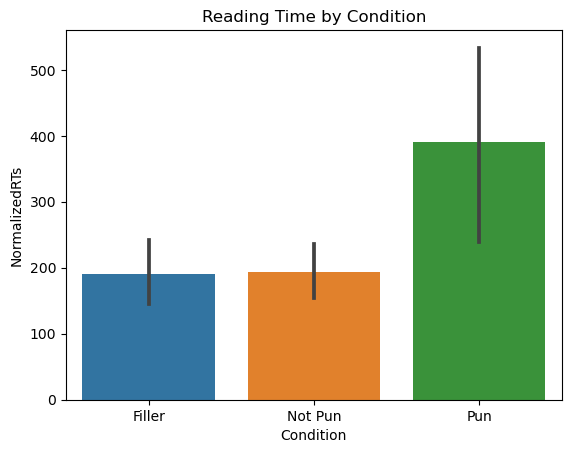

In [26]:
# Reading Times
sns.barplot(master_df, x="Condition", y="NormalizedRTs").set(title='Reading Time by Condition')

[Text(0.5, 1.0, 'Enjoyability by Condition')]

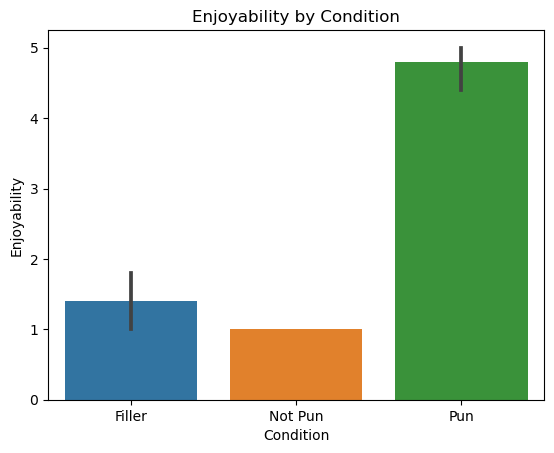

In [27]:
# Enjoyability
sns.barplot(master_df, x="Condition", y="Enjoyability").set(title='Enjoyability by Condition')

How related are enjoyability ratings and reading times? Do longer reading times equate to higher enjoyability ratings ( positive correlation)? Do longer reading times equate to lower enjoyability ratings (negative correlation)? Or, is there no correlation at all? We can check with a visual:

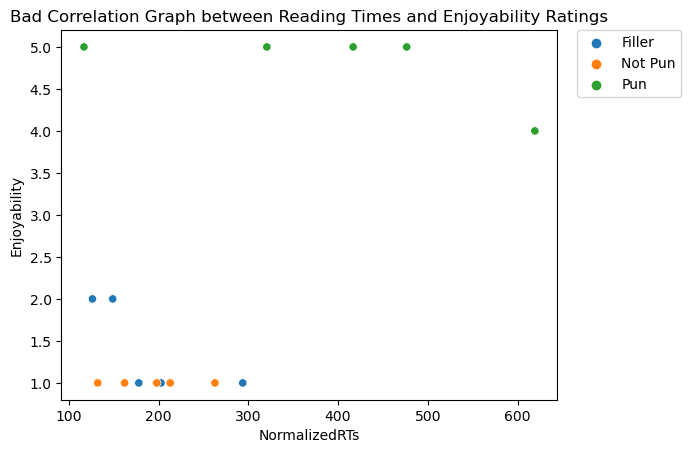

In [35]:
sns.scatterplot(data=master_df, x="NormalizedRTs", y="Enjoyability", hue="Condition").set(title="Bad Correlation Graph between Reading Times and Enjoyability Ratings")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

... and also some code:

In [29]:
# Checking correlations between RTs and Enjoyability (CLoser to 1 ~ More correlated)
master_df['NormalizedRTs'].corr(master_df['Enjoyability'])

0.5537250877426035